<a href="https://colab.research.google.com/github/DanielleSpitzig/Machine-Learning-Project/blob/master/CS680_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import sys and install all of the packages I need to download

import sys
!{sys.executable} -m pip install SwarmPackagePy
!{sys.executable} -m pip install pyswarms
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow


  Created wheel for SwarmPackagePy: filename=SwarmPackagePy-1.0.0a5-cp36-none-any.whl size=21164 sha256=2d3ac473a2868fcdb3268cd5280a5d1b80100e58b968a65672dc48989368e602
  Stored in directory: /root/.cache/pip/wheels/85/36/de/2013b37a4d6c0e1d3286cb6b51203e0b640823598410716d61
Successfully built SwarmPackagePy
     |████████████████████████████████| 102kB 6.2MB/s 


In [2]:
#Import all of the Python functions I am going to use

#General imports
import numpy as np
import matplotlib.pyplot as plt

#ABC algorithm imports
from random import randint, uniform, seed
from SwarmPackagePy import intelligence

#PSO algorithm imports
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

#Testing and training imports
import keras
from keras.datasets import mnist, cifar10, cifar100
import time

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


2019-12-15 15:29:02,796 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [0]:
#Start of ABC algorithm

"""
Artificial Bee Algorithm modified from SwarmPackagePy aba class
"""

class abc(intelligence.sw):


    def __init__(self, n, function, lb, ub, dimension, iteration):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        """
        super(abc, self).__init__()

        self.iteration = iteration
        self.dimension = dimension
        self.bounds = (lb, ub)
        self.num = n

        self.__function = function

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        self.Pbest = self.__agents[np.array([function(self.__agents)]).argmin()]
        self.Gbest = self.Pbest

        if n <= 10:
            self.count = n - n // 2, 1, 1, 1
        else:
            a = n // 10
            b = 5
            c = (n - a * b - a) // 2
            d = 2
            self.count = a, b, c, d


    def optimize(self):
        iteration = self.iteration
        dimension = self.dimension
        (lb, ub) = self.bounds
        function = self.__function
        count = self.count
        n = self.num
        Gbest = self.Gbest
        best_fit_iter = []

        for t in range(iteration):
            if t % 50 == 0:
              print(t)

            fitness = []
            fitness.extend(function(self.__agents))
            sort_fitness = fitness
            sort_fitness.sort()

            best = [self.__agents[i] for i in
                    [fitness.index(x) for x in sort_fitness[:count[0]]]]
            selected = [self.__agents[i]
                        for i in [fitness.index(x)
                                  for x in sort_fitness[count[0]:count[2]]]]

            newbee = self.__new(best, count[1], lb, ub) + self.__new(selected,
                                                                   count[3],
                                                                   lb, ub)
            m = len(newbee)
            self.__agents = newbee + list(np.random.uniform(lb, ub, (n - m,
                                                                   dimension)))

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)
            self.__agents = np.array(self.__agents).reshape((n, dimension))

            Pbest = self.__agents[
                np.array([function(self.__agents)]).argmin()]

            temp_Gbest = function(Gbest.reshape((1, dimension)))
            temp_Pbest = function(Pbest.reshape((1, dimension)))

            if temp_Pbest < temp_Gbest:
                Gbest = Pbest
                best_fit_iter.append(temp_Pbest)
            else:
                best_fit_iter.append(temp_Gbest)

        self._set_Gbest(Gbest)
        return best_fit_iter, Gbest

    def __new(self, l, c, lb, ub):

        bee = []
        for i in l:
            new = [self.__neighbor(i, lb, ub) for k in range(c)]
            bee += new
        bee += l

        return bee

    def __neighbor(self, who, lb, ub):

        neighbor = np.array(who) + uniform(-1, 1) * (
            np.array(who) - np.array(
                self.__agents[randint(0, len(self.__agents) - 1)]))
        neighbor = np.clip(neighbor, lb, ub)

        return list(neighbor)

In [0]:
#Calling ABC into a function that trains NN weights

"""Code modified from the PySwarm documentation examples, now using ABC optimizer
updated from the SwarmPackagePy in Python
    
    Credit for the PySwarm example to:
    Miranda L.J., (2018). 
    PySwarms: a research toolkit for Particle Swarm Optimization in Python. 
    Journal of Open Source Software, 3(21), 433, https://doi.org/joss.00433
    
"""

def ABC_NN(Xtrain, ytrain, Xtest, ytest, inputs, hidden, classes, num, max_iter = 100, pop = 50, bound = (-1, 1)):
    #in the main function so these variables are global to the following functions
    X_train = Xtrain
    y_train = ytrain
    X = Xtest
    y = ytest
    inputs = inputs
    hidden = hidden
    classes = classes
    num = num
    pop = pop
    lb = bound[0]
    up = bound[1]
    
    # Forward propagation
    def forward_prop(params, predict = False):
        """Forward propagation as objective function

        This computes for the forward propagation of the neural network, as
        well as the loss (or predic. It receives a set of parameters that must be
        rolled-back into the corresponding weights and biases.

        Inputs
        ------
        Xtrain: np.ndarray
            The training data of the neural network in an numpy array
        Xtest: np.ndarray
            The test data to make the prediction on at the end
        
        params: np.ndarray
            The dimensions should include an unrolled version of the
            weights and biases.
        vars: scalar
            Number of variables for each class in the neural network
        hidden: scalar
            Number of hidden layers 
        classes: scalar
            Number of classes in the data set
        num: scalar


        Returns
        -------
        if predict = false:
        float
            The computed negative log-likelihood loss given the parameters
        if predict = true:
        vector
            The predicted values for X
        """
        # Neural network architecture
        n_inputs = inputs
        n_hidden = hidden
        n_classes = classes

        start = 0
        W1_i = n_inputs*n_hidden
        b1_i = W1_i + n_hidden
        W2_i = b1_i + n_hidden*n_classes
        b2_i = W2_i + n_classes

        # Roll-back the weights and biases
        #If predict is true this is done with the optimized weights
        W1 = params[start:W1_i].reshape((n_inputs,n_hidden))
        b1 = params[W1_i:b1_i].reshape((n_hidden,))
        W2 = params[b1_i:W2_i].reshape((n_hidden,n_classes))
        b2 = params[W2_i:b2_i].reshape((n_classes,))

        # Perform forward propagation
        # Pre-activation in Layer 1 - what X we use depends on if it's the training or test data
        if predict == False:
            z1 = X_train.dot(W1) + b1
        else:
            z1 = X.dot(W1) + b1 
            
        a1 = np.tanh(z1)     # Activation in Layer 1
        z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2
        logits = z2          # Logits for Layer 2
        # Compute for the softmax of the logits
        exp_scores = np.exp(logits)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


        if predict == False:
            # Compute for the negative log likelihood
            N = num # Number of samples
            corect_logprobs = -np.log(probs[range(N), y_train])
            loss = np.sum(corect_logprobs) / N
            return loss
        else:
            #If we are doing a prediction then return the predicted values
            y_pred = np.argmax(logits, axis=1)
            return y_pred
            
    
    def f(x):
        """Higher-level method to do forward_prop in the
        whole colony.

        Inputs
        ------
        x: numpy.ndarray of shape (num_employers, dimensions)
            The swarm that will perform the search

        Returns
        -------
        numpy.ndarray of shape (num_employers, )
            The computed loss for each particle
        """

        num_employers = x.shape[0]

        j = [forward_prop(x[i]) for i in range(num_employers)]
        return np.array(j)
    
    
    %time
    # Initialize colony
    dim = (inputs * hidden) + (hidden * classes) + hidden + classes
    

    ABC = abc(pop, f, lb, up, dim, max_iter)
    (fitness, Gbest) = ABC.optimize()
    
    acc = (forward_prop(Gbest, predict = True) == y).mean()

    plt.plot(fitness)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.title("Fitness Evaluation of ABC Algorithm")

    return acc

In [0]:
"""Code modified from the PySwarm documentation examples
    Credit to:
    Miranda L.J., (2018). 
    PySwarms: a research toolkit for Particle Swarm Optimization in Python. 
    Journal of Open Source Software, 3(21), 433, https://doi.org/joss.00433
"""

def PSO_NN(Xtrain, ytrain, Xtest, ytest, inputs, hidden, classes, num, max_iter = 100, pop = 50):
    #in the main function so these variables are global to the following functions
    X_train = Xtrain
    y_train = ytrain
    X = Xtest
    y = ytest
    inputs = inputs
    hidden = hidden
    classes = classes
    num = num
    max_iter = max_iter
    pop = pop
    
    # Forward propagation
    def forward_prop(params, predict = False):
        """Forward propagation as objective function

        This computes for the forward propagation of the neural network, as
        well as the loss. It receives a set of parameters that must be
        rolled-back into the corresponding weights and biases.

        Inputs
        ------
        Xtrain: np.ndarray
            The training data of the neural network in an numpy array
        Xtest: np.ndarray
            The test data to make the prediction on at the end
        
        params: np.ndarray
            The dimensions should include an unrolled version of the
            weights and biases.
        vars: scalar
            Number of variables for each class in the neural network
        hidden: scalar
            Number of hidden layers 
        classes: scalar
            Number of classes in the data set
        num: scalar


        Returns
        -------
        if predict = false:
        float
            The computed negative log-likelihood loss given the parameters
        if predict = true:
        vector
            The predicted values for X
        """
        # Neural network architecture
        n_inputs = inputs
        n_hidden = hidden
        n_classes = classes
        
        start = 0
        W1_i = n_inputs*n_hidden
        b1_i = W1_i + n_hidden
        W2_i = b1_i + n_hidden*n_classes
        b2_i = W2_i + n_classes

        # Roll-back the weights and biases
        #If predict is true this is done with the optimized weights
        W1 = params[start:W1_i].reshape((n_inputs,n_hidden))
        b1 = params[W1_i:b1_i].reshape((n_hidden,))
        W2 = params[b1_i:W2_i].reshape((n_hidden,n_classes))
        b2 = params[W2_i:b2_i].reshape((n_classes,))

        # Perform forward propagation
        # Pre-activation in Layer 1 - what X we use depends on if it's the training or test data
        if predict == False:
            z1 = X_train.dot(W1) + b1
        else:
            z1 = X.dot(W1) + b1 
            
        a1 = np.tanh(z1)     # Activation in Layer 1
        z2 = a1.dot(W2) + b2 # Pre-activation in Layer 2
        logits = z2          # Logits for Layer 2

        # Compute for the softmax of the logits
        exp_scores = np.exp(logits)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        if predict == False:
            # Compute for the negative log likelihood
            N = num # Number of samples
            corect_logprobs = -np.log(probs[range(N), y_train])
            loss = np.sum(corect_logprobs) / N
            return loss
        else:
            #If we are doing a prediction then return the predicted values
            y_pred = np.argmax(logits, axis=1)
            return y_pred
            
    
    def f(x):
        """Higher-level method to do forward_prop in the
        whole colony.

        Inputs
        ------
        x: numpy.ndarray of shape (n_particles, dimensions)
            The swarm that will perform the search

        Returns
        -------
        numpy.ndarray of shape (n_particles, )
            The computed loss for each particle
        """
        n_particles = x.shape[0]
        j = [forward_prop(x[i]) for i in range(n_particles)]
        return np.array(j)
    
    
    %time
    # Initialize colony
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

    # Call instance of PSO
    dimensions = (inputs * hidden) + (hidden * classes) + hidden + classes
    optimizer = ps.single.GlobalBestPSO(n_particles=pop, dimensions=dimensions, options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=max_iter)
    
    acc = (forward_prop(pos, predict = True) == y).mean()
    
    # Obtain cost history from optimizer instance
    cost_history = optimizer.cost_history

    # Plot!
    plot_cost_history(cost_history)
    plt.title("Fitness Evaluation of PSO Algorithm")
    plt.ylabel("Cost")
    plt.xlabel("Iteration")
    plt.show()

    return acc

In [0]:
def DeepNN(Xtrain, Xtest, Ytrain, Ytest, num_classes, hidden = 20, opt = "PSO", max_iter = 100, pop = 50, bound = (-1, 1)):
    """
    Parameters:
    Xtrain, Ytrain: np.ndarrays
        training data set and its labels - used for training (minimizes log-loss)
    Xtest, Ytest: np.ndarrays
        test data and its label - used for prediction
    num_classes: scalar
        number of classes
    hidden: scalar
        number of hidden layers in the neural network - is arbitrary, default is 20
    opt: str
        Whether PSO or ABC algorithm is being used for optimization
        
    Returns:
    acc: float
        accuracy of the trained model on the test data
    total_time: float
        amount of time (in seconds) the model took to run
    """
    #Number of inputs is the number of variables
    inputs = Xtrain.shape[1]
    #Number of classes is self-explanatory - is inputted for each dataset
    classes = num_classes
    #num is the number of samples in the training data
    num = Xtrain.shape[0]
    
    start_time = time.clock()
    
    if opt == "PSO":
        acc = PSO_NN(Xtrain, Ytrain, Xtest, Ytest, inputs, hidden, classes, num, max_iter, pop)
    else:
        acc = ABC_NN(Xtrain, Ytrain, Xtest, Ytest, inputs, hidden, classes, num, max_iter, pop, bound)
    
    total_time = time.clock() - start_time
    
    return total_time, acc

In [0]:
thyroid = np.genfromtxt('php3YXJ45.csv', delimiter=',')
#The first row is the header - get rid of it
thyroid = thyroid[1:,:]
#The last column is the class - save as y
y = thyroid[:, -1]
#Give classes as 0 to n-1 and not 1 to n (for indexing later)
for i in range(len(y)):
  y[i] = y[i] - 1
y = y.astype(int)

#split the data up - take 20% for testing and the other 80% is used for training
indices = np.random.permutation(thyroid.shape[0])
n = thyroid.shape[0] - int(thyroid.shape[0]/5)
training_idx, test_idx = indices[:n], indices[n:]
train, test = thyroid[training_idx,:], thyroid[test_idx,:]

#normalize and the have the weights bounded by -1, 1
train = train/train.max()
test = test/test.max()

ytrain, ytest = y[training_idx], y[test_idx]

#Only take the unique elements in y as the number of classes
classes = len(set(y))
hidden = 10


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
0
50
100
150
200
250
300
350
400
450


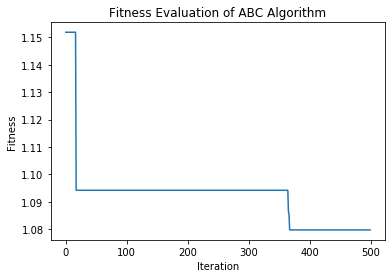

In [209]:
thy_ABC_time, thy_ABC_acc = DeepNN(train, test, ytrain, ytest, classes, hidden, opt = "ABC", max_iter = 500, pop = 50, bound = (-1, 1))

In [210]:
print(thy_ABC_acc, thy_ABC_time)

0.6053571428571428 218.5672709999999


2019-12-15 21:57:32,521 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/500

pyswarms.single.global_best:   0%|          |0/500, best_cost=1.24

pyswarms.single.global_best:   0%|          |1/500, best_cost=1.24

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs




pyswarms.single.global_best:   0%|          |1/500, best_cost=1.2 

pyswarms.single.global_best:   0%|          |2/500, best_cost=1.2

pyswarms.single.global_best:   0%|          |2/500, best_cost=1.15

pyswarms.single.global_best:   1%|          |3/500, best_cost=1.15

pyswarms.single.global_best:   1%|          |3/500, best_cost=1.13

pyswarms.single.global_best:   1%|          |4/500, best_cost=1.13

pyswarms.single.global_best:   1%|          |4/500, best_cost=1.13

pyswarms.single.global_best:   1%|          |5/500, best_cost=1.13

pyswarms.single.global_best:   1%|          |5/500, best_cost=1.12

pyswarms.single.global_best:   1%|          |6/500, best_cost=1.12

pyswarms.single.global_best:   1%|          |6/500, best_cost=1.12

pyswarms.single.global_best:   1%|▏         |7/500, best_cost=1.12

pyswarms.single.global_best:   1%|▏         |7/500, best_cost=1.11

pyswarms.single.global_best:   2%|▏         |8/500, best_cost=1.11

pyswarms.single.global_best:   2%|▏         |8/

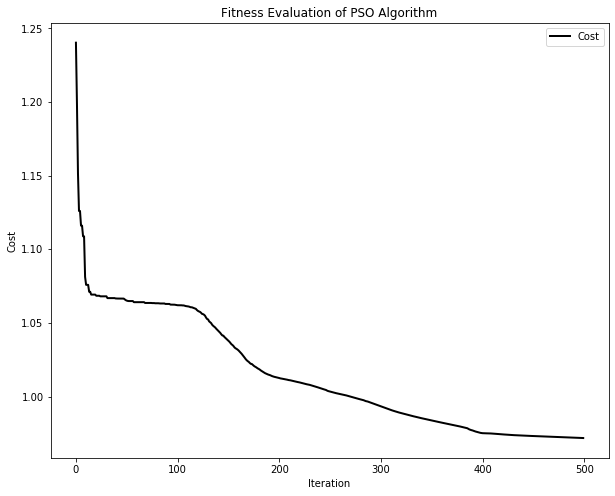

In [211]:
thy_PSO_time, thy_PSO_acc = DeepNN(train, test, ytrain, ytest, classes, hidden, opt = "PSO", max_iter = 500, pop = 50)

In [212]:
print(thy_PSO_acc, thy_PSO_time)

0.6071428571428571 113.04174899999998


In [0]:
def is_float(string):
    """ True if given string is float else False"""
    try:
        return float(string)
    except ValueError:
        return False

cancer = []
with open('WDBC.dat', 'r') as f:
    d = f.readlines()
    for i in d:
        k = i.rstrip().split(",")
        cancer.append([float(i) if is_float(i) else i for i in k]) 

cancer = np.array(cancer, dtype='O')
#First column is ID number - unique to every patient, so is unneed
#Second column is diagnosis (M = malignant, B = benign) - put into y
y_can = cancer[:, 1]
cancer = cancer[:, 2:]

#Get my classes to integers
for i in range(len(y_can)):
  if y_can[i] == 'M':
    y_can[i] = 0
  elif y_can[i] == 'B':
    y_can[i] = 1

y_can = y_can.astype(int)

#Ran into issue where my 0s where some integers were coming out as strings
#If that's the case check and return as integers
temp = list(cancer.flatten())
for i in range(len(temp)):
  if isinstance(temp[i], str):
    temp[i] = int(i)

cancer = np.array(temp).reshape(cancer.shape)

#split the data up - take 20% for testing and the other 80% is used for training
indices = np.random.permutation(cancer.shape[0])
n = cancer.shape[0] - int(cancer.shape[0]/5)
training_idx, test_idx = indices[:n], indices[n:]
can_train, can_test = cancer[training_idx,:], cancer[test_idx,:]

can_train = can_train/can_train.max()
can_test = can_test/can_test.max()

can_ytrain, can_ytest = y_can[training_idx], y_can[test_idx]

classes = 2
hidden = 20

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
0
50
100
150
200
250
300
350
400
450


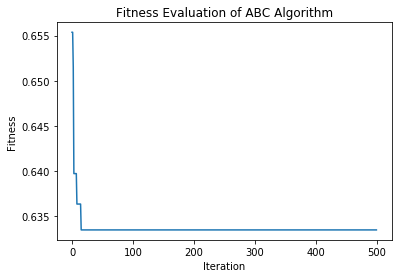

In [273]:
can_ABC_time, can_ABC_acc = DeepNN(can_train, can_test, can_ytrain, can_ytest, classes, hidden, opt = "ABC", max_iter = 500, pop = 50, bound = (0, 1))

In [274]:
print(can_ABC_time, can_ABC_acc)

76.77275400000144 0.6283185840707964


2019-12-15 22:36:23,783 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/500

pyswarms.single.global_best:   0%|          |0/500, best_cost=0.657

pyswarms.single.global_best:   0%|          |0/500, best_cost=0.655

pyswarms.single.global_best:   0%|          |0/500, best_cost=0.647

pyswarms.single.global_best:   1%|          |3/500, best_cost=0.647

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs




pyswarms.single.global_best:   1%|          |3/500, best_cost=0.641

pyswarms.single.global_best:   1%|          |3/500, best_cost=0.641

pyswarms.single.global_best:   1%|          |5/500, best_cost=0.641

pyswarms.single.global_best:   1%|          |5/500, best_cost=0.639

pyswarms.single.global_best:   1%|          |5/500, best_cost=0.639

pyswarms.single.global_best:   1%|          |5/500, best_cost=0.623

pyswarms.single.global_best:   2%|▏         |8/500, best_cost=0.623

pyswarms.single.global_best:   2%|▏         |8/500, best_cost=0.623

pyswarms.single.global_best:   2%|▏         |8/500, best_cost=0.621

pyswarms.single.global_best:   2%|▏         |10/500, best_cost=0.621

pyswarms.single.global_best:   2%|▏         |10/500, best_cost=0.607

pyswarms.single.global_best:   2%|▏         |10/500, best_cost=0.58 

pyswarms.single.global_best:   2%|▏         |10/500, best_cost=0.548

pyswarms.single.global_best:   3%|▎         |13/500, best_cost=0.548

pyswarms.single.global_best

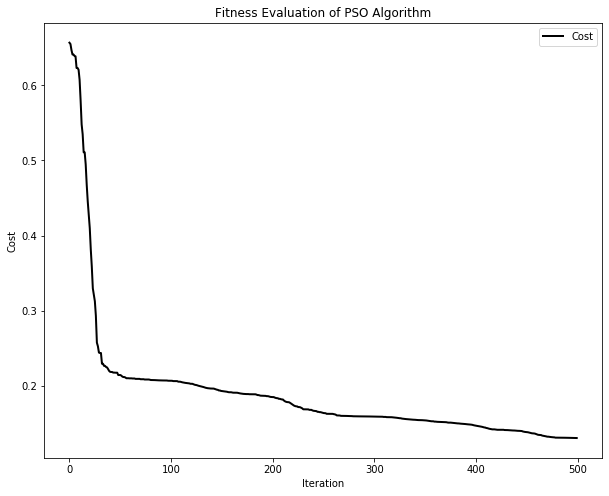

In [271]:
can_PSO_time, can_PSO_acc = DeepNN(can_train, can_test, can_ytrain, can_ytest, classes, hidden, opt = "PSO", max_iter = 500, pop = 50, bound = (-1, 1))

In [272]:
print(can_PSO_time, can_PSO_acc)

37.998201000002155 0.9380530973451328


In [0]:
def new_size(x):
  new_x = x.reshape((x.shape[0],x.shape[1]*x.shape[2]))
  return new_x

In [277]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
Xtrain = new_size(x_train)
Xtest = new_size(x_test)

Xtrain = Xtrain/Xtrain.max()
Xtest = Xtest/Xtest.max()

classes = 10
hidden = 5

[9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6 0 7 6 1
 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1]


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
0
50


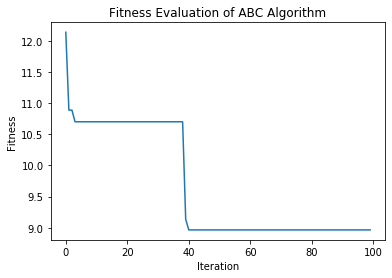

In [281]:
mnist_ABC_time, mnist_ABC_acc = DeepNN(Xtrain, Xtest, y_train, y_test, classes, hidden, opt = 'ABC', max_iter = 100, pop = 20, bound = (-10, 10))

In [282]:
print(mnist_ABC_time, mnist_ABC_acc)

1460.4372140000014 0.1582


2019-12-15 23:15:20,563 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/100

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.48 µs




pyswarms.single.global_best:   0%|          |0/100, best_cost=2.37

pyswarms.single.global_best:   1%|          |1/100, best_cost=2.37

pyswarms.single.global_best:   1%|          |1/100, best_cost=2.37

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.37

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.37

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.37

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.37

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.37

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.37

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.37

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.37

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2.37

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2.3 

pyswarms.single.global_best:   7%|▋         |7/100, best_cost=2.3

pyswarms.single.global_best:   7%|▋         |7/

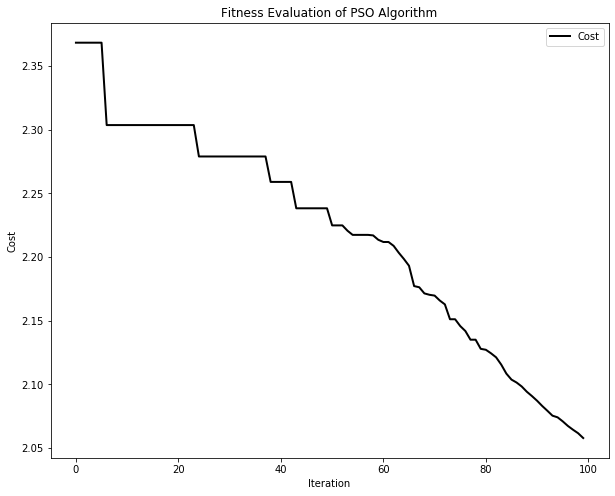

In [283]:
mnist_PSO_time, mnist_PSO_acc = DeepNN(Xtrain, Xtest, y_train, y_test, classes, hidden, opt = "PSO", max_iter = 100, pop = 20)

In [284]:
print(mnist_PSO_acc, mnist_PSO_time)

0.2698 688.6942429999981


In [0]:
from sklearn import datasets

iris = datasets.load_iris()

X = iris.data
y = iris.target

#split the data up - take 20% for testing and the other 80% is used for training
ind = np.random.permutation(X.shape[0])
num = X.shape[0] - int(X.shape[0]/5)
training_idx, test_idx = ind[:num], ind[num:]
X_train, X_test = X[training_idx,:], X[test_idx,:]

X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

Ytrain, Ytest = y[training_idx], y[test_idx]

classes = 3
hidden = 100

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
0
50
100
150


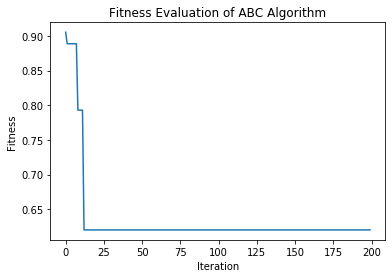

In [291]:
iris_ABC_time, iris_ABC_acc = DeepNN(X_train, X_test, Ytrain, Ytest, classes, hidden, opt = 'ABC', max_iter = 200, pop = 50, bound = (-1, 1))

In [292]:
print(iris_ABC_time, iris_ABC_acc)

10.504076000001078 0.8


2019-12-15 23:43:05,035 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/200

pyswarms.single.global_best:   0%|          |0/200, best_cost=1.08

pyswarms.single.global_best:   0%|          |0/200, best_cost=1.08

pyswarms.single.global_best:   0%|          |0/200, best_cost=1.08

pyswarms.single.global_best:   2%|▏         |3/200, best_cost=1.08

pyswarms.single.global_best:   2%|▏         |3/200, best_cost=1.08

pyswarms.single.global_best:   2%|▏         |3/200, best_cost=1.08

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs




pyswarms.single.global_best:   2%|▏         |3/200, best_cost=1.08

pyswarms.single.global_best:   2%|▏         |3/200, best_cost=0.97

pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.97

pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.97

pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.883

pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.756

pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.756

pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.756

pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.756

pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.756

pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.677

pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.561

pyswarms.single.global_best:   8%|▊         |15/200, best_cost=0.561

pyswarms.single.global_best:   8%|▊         |15/200, best_cost=0.561

pyswarms.single.global_best: 

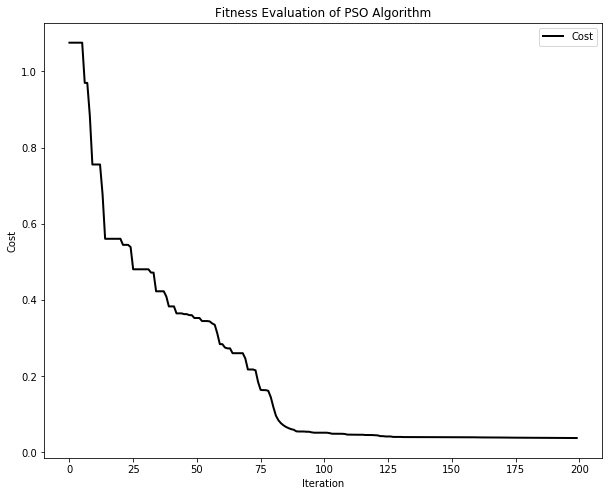

In [293]:
iris_PSO_time, iris_PSO_acc = DeepNN(X_train, X_test, Ytrain, Ytest, classes, hidden, opt = 'PSO', max_iter = 200, pop = 50, bound = (-1, 1))

In [294]:
print(iris_PSO_time, iris_PSO_acc)

6.5692979999985255 0.9333333333333333
